# where is floating?

##
### Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [1]:
!pwd

/Users/home/whitefar/DATA/Jupyter/RADAR/RADAR_MAP_correct_offset


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
from rasterio.windows import Window
import string
import matplotlib.gridspec as gridspec

In [3]:
import matplotlib.path


In [4]:
from scipy.integrate import quad
import time
import pickle

In [5]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')

# thickness_interpolated = np.load(direc +'ice_thickn.npy')
extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'ice_base.npy')
# ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)
REMA_surf = np.load(direc +'REMA_surf.npy')


In [6]:
# from DATA/Jupyter/RADAR/RADAR_MAP/44_where_float.ipynb
vertical_offset_from_floatation = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/vertical_offset_from_floatation.npy')


In [7]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']

In [8]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy')
#ice thickness
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_ice_thickn.npy')
#ice base
ib_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_icebase.npy')
it = it_new[50,:]
ib = ib_new[50,:]
x = x_new[50,:]
y = y_new[50,:]
#mid channel
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it,'ice_base':ib})
points = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf_mid = gpd.GeoDataFrame(mid,geometry=points,crs="EPSG:3031")
tmp_dfp = [Point.distance(gdf_mid.geometry.iloc[i]) for i,Point in enumerate(gdf_mid.geometry.iloc[1:])]
tmp_dfp[:0] = [0]
gdf_mid['dx'] = pd.Series(tmp_dfp) #note the 1:, equivalent to i+1
gdf_mid['distan_cum'] = gdf_mid.dx.cumsum()

f = sp.interpolate.interp1d(gdf_mid.y,gdf_mid.distan_cum)

In [9]:
buff = LineString(gdf_mid.geometry.tolist()).buffer(2000)

In [10]:
gdf_mid.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/centre_channel.gpkg', driver='GPKG')

In [11]:
geoid_correction = geoid_correction*np.ones(vertical_offset_from_floatation.shape)
geoid_correction[vertical_offset_from_floatation==0] =  np.nan

In [12]:
REMA_surf[vertical_offset_from_floatation==0.0] = np.nan

In [13]:
vertical_offset_from_floatation[vertical_offset_from_floatation==0]=np.nan

In [14]:
vof_nonan = vertical_offset_from_floatation.copy()
vof_nonan[np.isnan(vof_nonan)] = 0

In [15]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [16]:
grounded = np.array([[1,10],
                     [np.nan,-14]])

In [17]:
buff_list = [i for i in zip(buff.exterior.coords.xy[0],buff.exterior.coords.xy[1])]

In [18]:
poly_verts = buff_list
path = matplotlib.path.Path(poly_verts)

In [19]:
# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
xv, yv
x, y = xv.flatten(), yv.flatten()

points = np.vstack((x,y)).T

contained = path.contains_points(points)
                           

In [20]:
contained_a = contained.reshape(xv.shape)

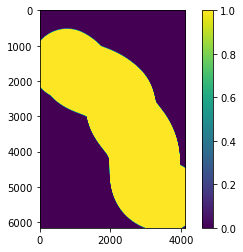

In [21]:
plt.imshow(contained_a)
plt.colorbar()

In [22]:
# remove anything less than 5m above floating.
grounded = vertical_offset_from_floatation.copy()
grounded[(vof_nonan>5)] = 1
grounded[(vof_nonan<5)] = 0
grounded[contained_a==1] = 0
grounded_nonan = grounded.copy()
grounded[np.isnan(vertical_offset_from_floatation)] = np.nan

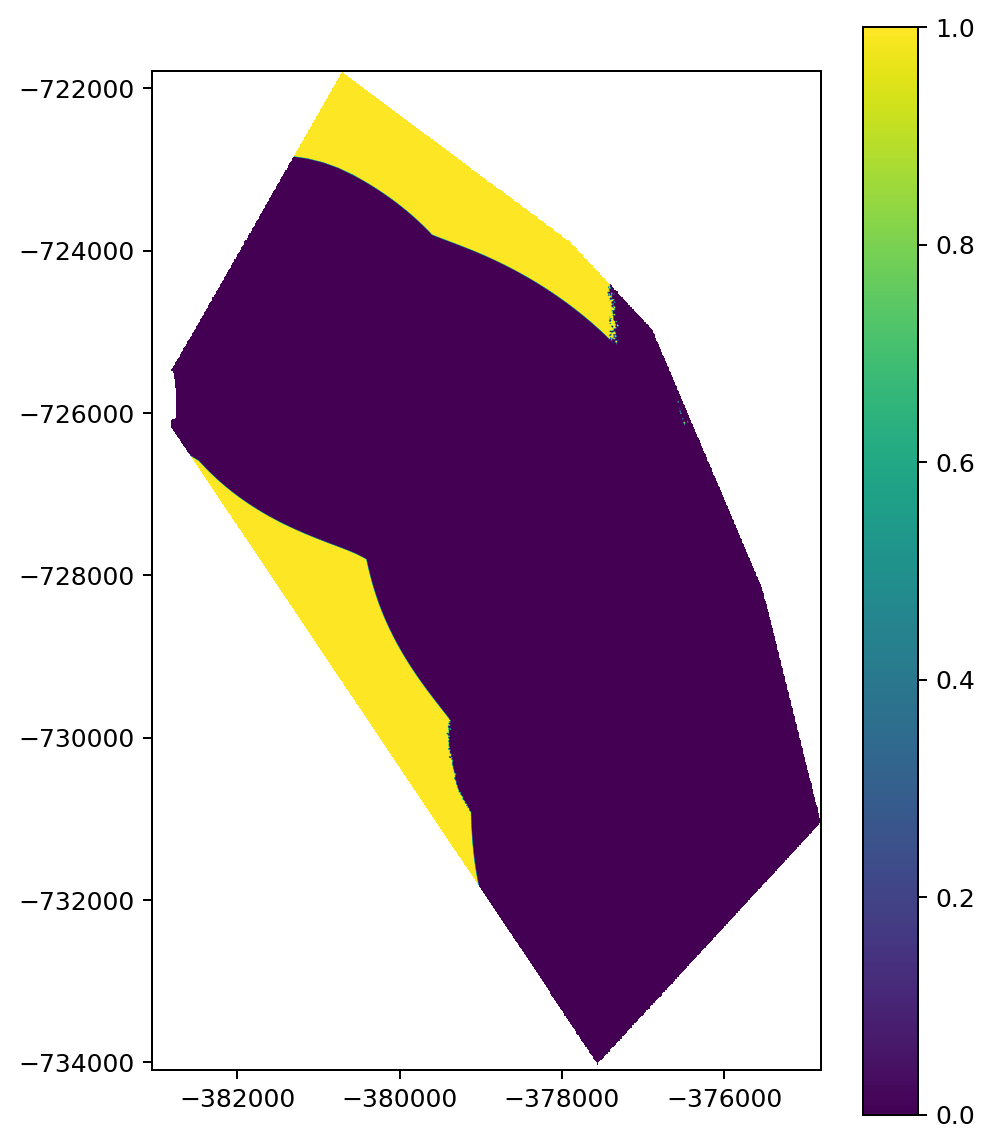

In [23]:
plt.figure( dpi=180,figsize=(6,8))
plt.imshow(grounded,extent=np.array(extent_l2l))
# plt.plot(buff.exterior.coords.xy[0],buff.exterior.coords.xy[1])
plt.colorbar()
plt.show()

In [24]:
np.save('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable.npy',grounded)
np.save('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_xv.npy',xv)
np.save('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_yv.npy',yv)
np.save('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_nonan.npy',grounded_nonan)


In [1]:
!ls /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/

centre_channel.gpkg  stable_mask.nc  vertical_offset_from_floatation.nc


In [40]:
!cp /Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/vertical_offset_from_floatation.npy /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/vertical_offset_from_floatation.npy

In [ ]:
scp whitefar@kahutea.geo.vuw.ac.nz:/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/* /home/arran/PHD/DATA/STABLE/

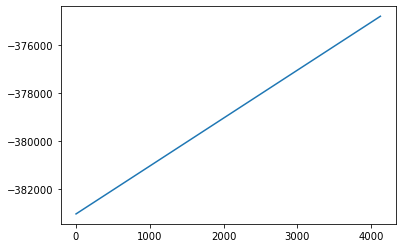

In [42]:
plt.plot(xv[0,:])

In [44]:
import xarray as xr


In [46]:
da = xr.DataArray(
    data=grounded,
    dims=["y", "x"],
    coords=(yv[:,0],xv[0,:]),
#     attrs=dict(
#         stable_mask=self.total_run_time,
#         ),
    )
da.to_dataset(name="ice_base").to_netcdf("/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_mask"+".nc")

In [47]:
da = xr.DataArray(
    data=vertical_offset_from_floatation,
    dims=["y", "x"],
    coords=(yv[:,0],xv[0,:]),
#     attrs=dict(
#         stable_mask=self.total_run_time,
#         ),
    )
da.to_dataset(name="ice_base").to_netcdf("/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/vertical_offset_from_floatation"+".nc")